In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m'].sort_index()
mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m'].sort_index()
mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m'].sort_index()

In [6]:
def merton_ml_diff_vol(p0):
    vol = p0
    if vol < 0.0:
        return np.inf
    dx = np.diff(data)
    t = (np.array(list(range(len(data)))) + 1)/252
    dt = np.array([1/252]*len(dx))
    sigma = vol * np.sqrt(dt)
    mu =  alpha * dt
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [9]:
def rolling_merton(db=mosprime3m, periods=21):
    date_start_end = (pd.date_range(end = db.index.min(), periods=1, freq='d') + periods - 1).strftime('%Y-%m-%d')[0]
    df_cal_merton = pd.DataFrame(columns=["alpha", "vol", "mean", "std"], index=np.array(db.index[periods:]))
    for i in tqdm(range(len(df_cal_merton))):
        global data
        data = db.dropna().values[i:(periods+i)]
        dx = np.diff(data)
        dt = np.array([1/252]*len(dx))
        Y1 = dx
        X1 = np.array([1]*len(dx))
        model_i = sm.OLS(Y1, X1).fit()
        mean = np.mean(data)
        std = np.std(data)
        global alpha
        alpha = model_i.params/dt[0]
        vol = sop.fmin(merton_ml_diff_vol, [0.2], maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001, disp=0)
        df_cal_merton.iloc[i] = np.array([alpha, vol, mean, std])
    return df_cal_merton

In [10]:
db252_merton = rolling_merton(periods=252)

100%|██████████| 2469/2469 [00:12<00:00, 194.07it/s]


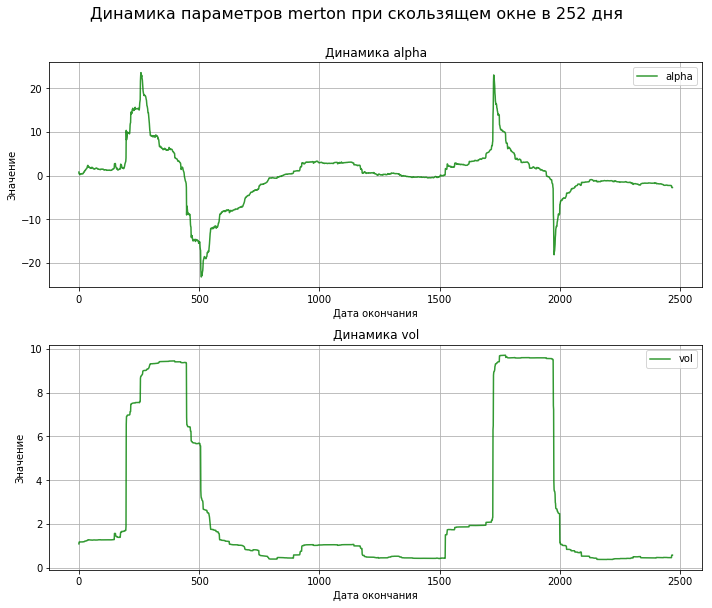

In [13]:
plt.figure(figsize=[10,8])

plt.subplot(2,1,1)
plt.plot(db252_merton['alpha'].values , 'g-',  alpha = 0.8, label = 'alpha')
plt.title('Динамика alpha')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(db252_merton['vol'].values , 'g-',  alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.suptitle('Динамика параметров merton при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
a = np.array(db252_merton['alpha'].values, dtype=float)
vol = np.array(db252_merton['vol'].values, dtype=float)

In [47]:
x = mosprime3m.values[:-252]
t252 = np.array([252/252]*len(a))
sigma252 = vol * np.sqrt(t252)
mu252 = x + a*t252
t1 = np.array([1/252]*len(a))
sigma1 = vol * np.sqrt(t1)
mu1 = x + a*t1
t21 = np.array([21/252]*len(a))
sigma21 = vol * np.sqrt(t21)
mu21 = x + a*t21

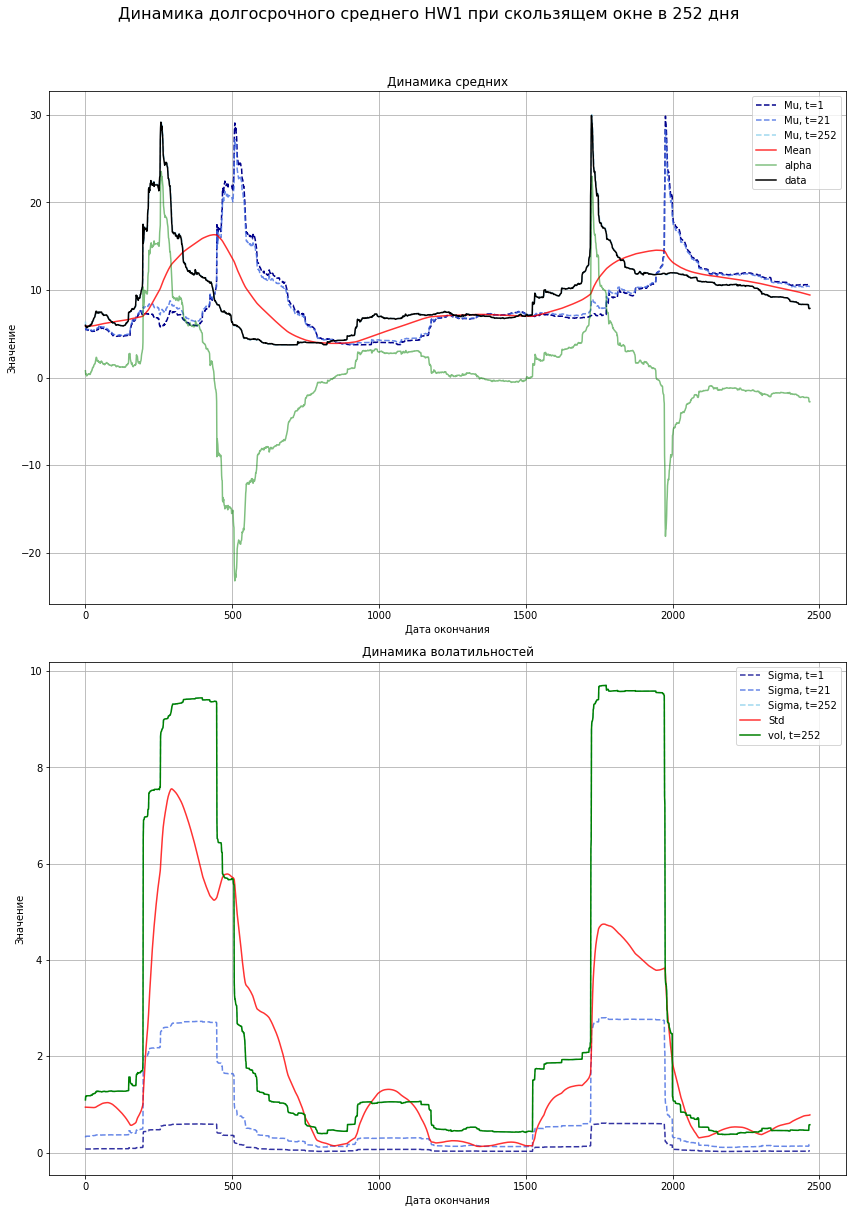

In [57]:
plt.figure(figsize=[12,16])

plt.subplot(2,1,1)
plt.plot(mu1 , '--', color='darkblue',  alpha = 1, label = 'Mu, t=1')
plt.plot(mu21 , '--', color='royalblue',  alpha = 0.8, label = 'Mu, t=21')
plt.plot(mu252 , '--', color='skyblue',  alpha = 0.8, label = 'Mu, t=252')
plt.plot(db252_merton['mean'].values , 'r-',  alpha = 0.8, label = 'Mean')
plt.plot(a , 'g-',  alpha = 0.5, label = 'alpha')
plt.plot(mosprime3m.values[252:] , 'black', label = 'data')
plt.title('Динамика средних')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
#plt.ylim([0,1])
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(sigma1 , '--', color='darkblue',  alpha = 0.8, label = 'Sigma, t=1')
plt.plot(sigma21 , '--', color='royalblue',  alpha = 0.8, label = 'Sigma, t=21')
plt.plot(sigma252 ,'--', color='skyblue',  alpha = 0.8, label = 'Sigma, t=252')
plt.plot(db252_merton['std'].values , 'r-',  alpha = 0.8, label = 'Std')
plt.plot(db252_merton['vol'].values , 'g-',  alpha = 1, label = 'vol, t=252')
plt.title('Динамика волатильностей')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
#plt.ylim([0,10])
plt.legend()
plt.grid()

plt.suptitle('Динамика долгосрочного среднего HW1 при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

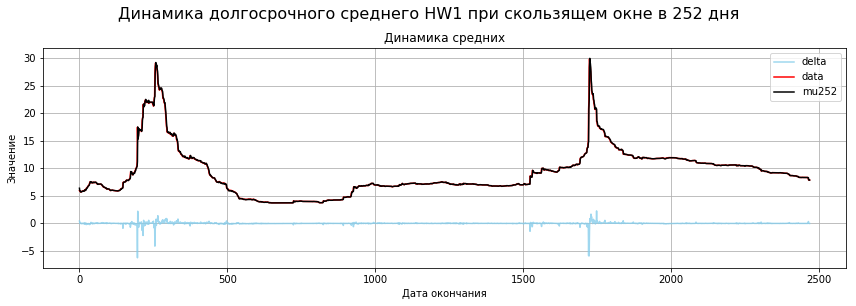

In [51]:
plt.figure(figsize=[12,4])

plt.plot(mu252-mosprime3m.values[252:]  , '-', color='skyblue',  alpha = 0.8, label = 'delta')
plt.plot(mosprime3m.values[252:] , 'r', label = 'data')
plt.plot(mu252 , 'black', label = 'mu252')
plt.title('Динамика средних')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
#plt.ylim([0,1])
plt.legend()
plt.grid()


plt.suptitle('Динамика долгосрочного среднего HW1 при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

In [56]:
data = mosprime3m_short.values
dx = np.diff(data)
dt = np.array([1/252]*len(dx))
Y1 = dx
X1 = np.array([1]*len(dx))
model = sm.OLS(Y1, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Tue, 13 Feb 2018   Prob (F-statistic):                nan
Time:                        21:44:04   Log-Likelihood:                 205.02
No. Observations:                 104   AIC:                            -408.0
Df Residuals:                     103   BIC:                            -405.4
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.003      1.216      0.227      -0.003       0.011
==============================================================================
Omnibus:                       43.514   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.118
Skew:                           1.261   Prob(JB):                     1.29e-44
Kurtosis:                       9.347   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y1 = x[1:]
X1 = np.array(x[:-1])
X1 = sm.add_constant(X1)
model = sm.OLS(Y1, X1).fit()
model.summary()